In [15]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow_addons.optimizers import AdamW

from train import make_X_y, encode_y, scale_X, quantile_X, grouped_train_test_split
#from model.create_model_1dcnn import create_model
from model.create_model_3stagenn import create_model
from eval import recall_at_k

In [16]:
def seed_everything(seed=24):
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(24)

In [17]:
df = pd.read_parquet("../../../../data/clean/clean.parquet")
df.shape

(986528, 991)

In [18]:
X, y = make_X_y(df)
X_train, X_test, y_train, y_test = grouped_train_test_split(X, y, y, test_size=0.2)
X_train_scale, X_test_scale = scale_X(X_train, X_test)
#X_train_scale, X_test_scale = quantile_X(X_train, X_test)

In [19]:
def pca_X(X_train, X_test, n_comp=50):
    pca = PCA(n_components=n_comp)
    feat_new = ['pca'+ str(i) for i in range(n_comp)]

    X_train_pca = pd.DataFrame(pca.fit_transform(X_train), columns=feat_new)
    X_test_pca = pd.DataFrame(pca.transform(X_test), columns=feat_new)
    return (X_train_pca, X_test_pca)

n_comp = 50
X_train_pca, X_test_pca = pca_X(X_train_scale, X_test_scale)

X_train = pd.concat([X_train_pca, pd.DataFrame(X_train_scale)], axis = 1)
X_test  = pd.concat([X_test_pca, pd.DataFrame(X_test_scale)], axis = 1)

In [20]:
num_classes = len(np.unique(y_train))
y_train_encode = encode_y(y_train)

In [21]:
BATCH_SIZE = 1024 #256

#Adam optimizer with a learning rate of 5e-3, 
#a weight decay of 1e-5
#a batch size of 256

In [22]:
train_dataset = Dataset.from_tensor_slices((X_train, y_train_encode))
label_dataset = Dataset.from_tensor_slices(y_train_encode)
dataset = Dataset.zip((train_dataset, label_dataset)).shuffle(100).batch(BATCH_SIZE)

In [23]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = create_model(num_classes, BATCH_SIZE, input_length=X_train.shape[1], embedding_size=32, hidden_size=1024, max_m=0.3)
    model.compile(loss=SparseCategoricalCrossentropy(),
                    optimizer=AdamW(learning_rate=5e-3, weight_decay=1e-5),
                    metrics=['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [24]:
EPOCHS = 20

model.fit(dataset,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1)

2022-07-01 14:42:06.658653: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 780746
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:340"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 1028
        }
      }
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TF

Epoch 1/20
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1
763/763 [==============================] - 40s 38ms/step - loss: 17.0671 - accuracy: 0.0077
Epoch 2/20
763/763 [==============================] - 29s 37ms/step - loss: 15.2242 - accuracy: 0.0086
Epoch 3/20
763/763 [==============================] - 29s 38ms/step - loss: 13.9870 - accuracy: 0.0085
Epoch 4/20
763/763 [==============================] - 29s 38ms/step - loss: 12.6788 - accuracy: 0.0083
Epoch 5/20
763/763 [==============================] 

In [26]:
#save_model(model, 'saved_model')
#model = load_model('saved_model')
embeddings_model = Model(inputs=model.get_layer('gene_expression_vector').input, outputs=model.get_layer('lambda_1').output) #get network up to embedding layer
embedded = embeddings_model.predict(X_test, verbose=1)

6431/6431 [==============================] - 24s 4ms/step


In [27]:
_, embedded_sample, _, labs_sample = grouped_train_test_split(embedded, y_test, y_test, test_size=300)
print(embedded_sample.shape)

recall = recall_at_k(embedded_sample, embedded, y_test)
quantile = minmax_scale(np.arange(1, embedded.shape[0]), feature_range=(0, 1))

auc = np.trapz(recall, quantile)

(11224, 32)


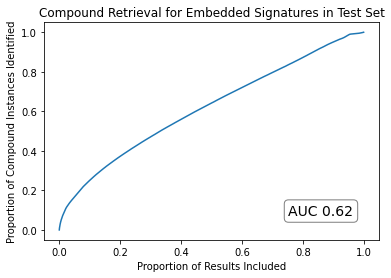

In [28]:
auc_lab = f"AUC {auc:.2f}"

fig, ax = plt.subplots()
ax.plot(quantile, recall)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.73, 0.1, auc_lab, transform=ax.transAxes, fontsize=14,
        verticalalignment='bottom', bbox=props)
plt.title("Compound Retrieval for Embedded Signatures in Test Set")
plt.xlabel("Proportion of Results Included")
plt.ylabel("Proportion of Compound Instances Identified")
plt.show()

In [ ]:
#0.0005 lr, 2048 batch, 25 epochs, got loss 7.83 and 0.81 auc
#max_m 0.15